<a href="https://colab.research.google.com/github/sysung/w266-final-project/blob/master/roberta/MisInformation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Misinformation in Social Media and New Sources

Download the dataset and unzip dataset

In [ ]:
!curl -O https://cs.uwaterloo.ca/~ppoupart/fact-check/WatClaimCheck.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1107M  100 1107M    0     0  15.4M      0  0:01:11  0:01:11 --:--:-- 16.4M


In [ ]:
!tar -xzf WatClaimCheck.tar.gz

Install necessary packages

In [ ]:
!pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 39.4 MB/s eta 0:00:00


In [ ]:
# RoBERTa
from transformers import RobertaTokenizerFast, TFRobertaModel
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder

import datetime as dt
import json
import keras
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf

from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  1


In [ ]:
def explode_dictionary(pd_df: pd.DataFrame, field: str) -> pd.DataFrame:
    '''Explodes a dictionary within a column as multiple columns and then drops the parent field'''
    return pd.concat([pd_df.drop(field, axis=1), pd_df[field].apply(pd.Series)], axis=1)


def clean_pd_df(pd_df: pd.DataFrame) -> pd.DataFrame:
    '''Extracts field from dataframe, casts review_date to datetime and removes id'''

    print("Extracting fields from metadata")
    pd_df = explode_dictionary(pd_df, 'metadata')

    print("Extracting fields from label")
    pd_df = explode_dictionary(pd_df, 'label')

    # Set claim_date as review_date if review_date does not exist
    pd_df['review_date'].fillna(pd_df['claim_date'], inplace=True)

    # Convert review_date to date time
    pd_df['review_date'] = pd.to_datetime(pd_df['review_date'].str.split('T', expand=True)[0])

    # Drop ID
    pd_df = pd_df.drop(columns=['id'])

    return pd_df


def download_dataset(dataset_fp: str) -> tuple:
    '''
    Reads the WatClaimCheck dataset from the filepath and returns a pandas dataframe of the train, valid, and test datasets
    Reads the WatClaimCheck dataset from the filepath and returns a pandas dataframe of the train, valid, and test datasets

    Parameters:
    dataset_fp (str): Filepath of dataset

    Returns:
    tuple: Train, Valid, Test Pandas Dataframes
    '''

    # Get full path of json files
    train_json_fp = os.path.join(dataset_fp, 'train.json')
    valid_json_fp = os.path.join(dataset_fp, 'valid.json')
    test_json_fp = os.path.join(dataset_fp, 'test.json')

    # Get pandas dataframe from json
    train_pd_df = pd.read_json(train_json_fp)
    valid_pd_df = pd.read_json(valid_json_fp)
    test_pd_df = pd.read_json(test_json_fp)

    # Get all of the data corresponding to the metadata and labels
    clean_train_pd_df = clean_pd_df(train_pd_df)
    clean_valid_pd_df = clean_pd_df(valid_pd_df)
    clean_test_pd_df = clean_pd_df(test_pd_df)

    return clean_train_pd_df, clean_valid_pd_df, clean_test_pd_df

def download_article(dataset_fp: str, article_file: str) -> dict:
    '''
    Downloads an article from the WatClaimCheck Dataset

    Parameters:
    dataset_fp   (str): Filepath of dataset
    article_file (str): Filepath of article

    Returns:
    dict: Article JSON
    '''

    # Read articles as json
    full_article_fp = open(os.path.join(dataset_fp, 'articles', article_file))
    json_data = json.load(full_article_fp)
    full_article_fp.close()

    return json_data

## Read and Preprocess Data

In [ ]:
DATASET_FP = "./WatClaimCheck_dataset"

In [ ]:
# Retrieve dataset
train_df, valid_df, test_df = download_dataset(DATASET_FP)
print(train_df.count())
print(valid_df.count())
print(test_df.count())

Extracting fields from metadata
Extracting fields from label
Extracting fields from metadata
Extracting fields from label
Extracting fields from metadata
Extracting fields from label
claimant            19751
claim               26976
claim_date          19190
review_date         26976
premise_articles    26976
reviewer_name       26976
reviewer_site       26976
review_url          26976
rating              26976
original_rating     26976
review_article      26976
dtype: int64
claimant            2476
claim               3372
claim_date          2407
review_date         3372
premise_articles    3372
reviewer_name       3372
reviewer_site       3372
review_url          3372
rating              3372
original_rating     3372
review_article      3372
dtype: int64
claimant            2450
claim               3373
claim_date          2384
review_date         3373
premise_articles    3373
reviewer_name       3373
reviewer_site       3373
review_url          3373
rating              3373
origi

The review article content when combining with the claim is being cut because there is usually a lot of unwanted sentences at the top and bottom of the article such as links, bullet points, and unrelated sentences.

The next step is to look into SumBasic extractive summarization to get the most meaningful sentences..

In [ ]:
# Get review article content
train_df['review_article_content'] = train_df['review_article'].apply(lambda x: ' '.join(download_article(DATASET_FP, x)))
valid_df['review_article_content'] = valid_df['review_article'].apply(lambda x: ' '.join(download_article(DATASET_FP, x)))
test_df['review_article_content'] = test_df['review_article'].apply(lambda x: ' '.join(download_article(DATASET_FP, x)))

# Get premise article content
train_df['premise_article_content'] = train_df['premise_articles'].apply(lambda x: [' '.join(download_article(DATASET_FP, file)) for file in x.values()])
valid_df['premise_article_content'] = valid_df['premise_articles'].apply(lambda x: [' '.join(download_article(DATASET_FP, file)) for file in x.values()])
test_df['premise_article_content'] = test_df['premise_articles'].apply(lambda x: [' '.join(download_article(DATASET_FP, file)) for file in x.values()])

# Combine claim and review article content
article_start_idx = 1000
article_end_idx = -1000
train_df['claim_and_review_article'] = "Claim: " + train_df['claim'] + "\n\nContext:\n" + train_df['review_article_content'].apply(lambda x: x[article_start_idx:article_end_idx])
valid_df['claim_and_review_article'] = "Claim: " + valid_df['claim'] + "\n\nContext:\n" + valid_df['review_article_content'].apply(lambda x: x[article_start_idx:article_end_idx])
test_df['claim_and_review_article'] = "Claim: " + test_df['claim'] + "\n\nContext:\n" + test_df['review_article_content'].apply(lambda x: x[article_start_idx:article_end_idx])

# Add question
# train_df['question'] = train_df['claim'].apply(lambda x: f"Is the claim \"{x}\" true, false, or partially true/false?")
# valid_df['question'] = valid_df['claim'].apply(lambda x: f"Is the claim \"{x}\" true, false, or partially true/false?")
# test_df['question'] = test_df['claim'].apply(lambda x: f"Is the claim \"{x}\" true, false, or partially true/false?")

## DPR Model

In [ ]:
# dpr_context_encoder_tokenizer = DPRContextEncoderTokenizerFast.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
# dpr_context_encoder_model = TFDPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

# dpr_question_encoder_tokenizer = DPRQuestionEncoderTokenizerFast.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
# dpr_question_encoder_model = TFDPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

# dpr_reader_tokenizer = DPRReaderTokenizerFast.from_pretrained('facebook/dpr-reader-single-nq-base')
# dpr_reader_model = TFDPRReader.from_pretrained('facebook/dpr-reader-single-nq-base')

In [ ]:
# train_length = math.floor(len(train_df) * 0.001)
# dpr_context_msl = 512
# dpr_question_msl = 128
# print(f"Training size: {train_length:,}")

# print("Tokenizing Context...")
# dpr_context_tokens = dpr_context_encoder_tokenizer(
#     train_df['review_article_content'].to_list()[:train_length],
#     max_length = dpr_context_msl,
#     padding = 'max_length',
#     truncation = True,
#     return_tensors = 'tf'
# )

# print("Tokenizing Questions...")
# dpr_question_tokens = dpr_question_encoder_tokenizer(
#     train_df['question'].to_list()[:train_length],
#     max_length = dpr_question_msl,
#     padding = 'max_length',
#     truncation = True,
#     return_tensors = 'tf'
# )

# print("Infer Context Pooler Output")
# context_vector = dpr_context_encoder_model(dpr_context_tokens).pooler_output

# print("Infer Question Pooler Output")
# question_vector = dpr_question_encoder_model(dpr_question_tokens).pooler_output

# cosine_loss = tf.keras.losses.CosineSimilarity()
# similarity_score = cosine_loss(question_vector, context_vector)

# print(f"Similarity Score {similarity_score}")

## RoBERTa Model

In [ ]:
checkpoint = 'distilroberta-base'
roberta_tokenizer = RobertaTokenizerFast.from_pretrained(checkpoint)
roberta_model = TFRobertaModel.from_pretrained(checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
hidden_size = 50
learning_rate = 1e-5
dropout = 0.5
num_classes = 3
claim_article_msl = 512

input_ids = tf.keras.layers.Input(shape=(claim_article_msl,), dtype=tf.int64, name='input_ids_layer')
attention_mask = tf.keras.layers.Input(shape=(claim_article_msl,), dtype=tf.int64, name='attention_mask_layer')

roberta_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}

roberta_model.trainable = True
roberta_outputs = roberta_model(roberta_inputs)

pooler_token = roberta_outputs[1]

hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

hidden = tf.keras.layers.Dropout(dropout)(hidden)

classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

model.compile(
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.F1Score(average='macro')
    ]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   8211840   ['attention_mask_layer[0][0]',
 aModel)                     ngAndCrossAttentions(last_   0          'input_ids_layer[0][0]'] 

In [ ]:
# Set variables
batch_size = 12
epochs = 10
claim_article_msl = 512
string_date = str(dt.datetime.now()).replace(' ', '_')
checkpoint_dir = "/content/drive/MyDrive/w266_final_project_checkpoints/"
checkpoint_path = checkpoint_dir + "weights.{string_date}-{epoch:02d}-{val_loss:.2f}-{val_f1_score:.2f}.hdf5"
checkpoint = 'distilroberta-base'
encoder = OneHotEncoder(sparse_output=False)

# Create Train and Validation inputs
train_inputs = roberta_tokenizer.batch_encode_plus(
    train_df['claim_and_review_article'].to_list(),
    max_length = claim_article_msl,
    padding="max_length",
    truncation=True,
    return_tensors='tf'
)

train_labels = encoder.fit_transform(np.array(train_df['rating']).reshape(-1, 1))

valid_inputs = roberta_tokenizer.batch_encode_plus(
    valid_df['claim_and_review_article'].to_list(),
    max_length = claim_article_msl,
    padding="max_length",
    truncation=True,
    return_tensors='tf'
)

valid_labels = encoder.fit_transform(np.array(valid_df['rating']).reshape(-1, 1))

# Train model
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True)

model_history = model.fit(
    [train_inputs.input_ids, train_inputs.attention_mask], train_labels,
    validation_data=([valid_inputs.input_ids, valid_inputs.attention_mask], valid_labels),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[cp_callback]
)

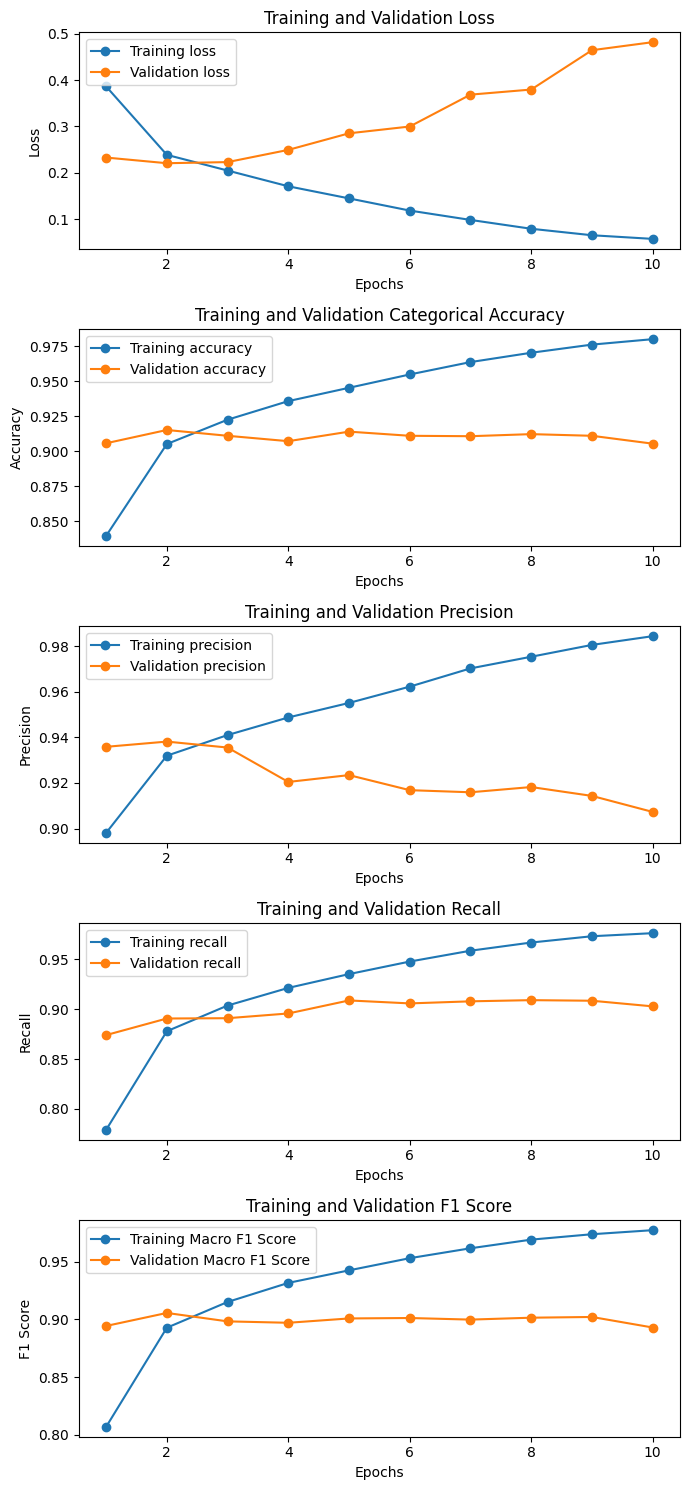

In [ ]:
history_keys = list(model_history.history.keys())

# Create subplots
fig, axes = plt.subplots(5, 1, figsize=(7, 15))
epochs = range(1, len(model_history.history['loss']) + 1)

axes[0].plot(epochs, model_history.history[history_keys[0]], 'o-', label='Training loss')
axes[0].plot(epochs, model_history.history[history_keys[5]], 'o-', label='Validation loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epochs, model_history.history[history_keys[1]], 'o-', label='Training accuracy')
axes[1].plot(epochs, model_history.history[history_keys[6]], 'o-', label='Validation accuracy')
axes[1].set_title('Training and Validation Categorical Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

axes[2].plot(epochs, model_history.history[history_keys[2]], 'o-', label='Training precision')
axes[2].plot(epochs, model_history.history[history_keys[7]], 'o-', label='Validation precision')
axes[2].set_title('Training and Validation Precision')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Precision')
axes[2].legend()

axes[3].plot(epochs, model_history.history[history_keys[3]], 'o-', label='Training recall')
axes[3].plot(epochs, model_history.history[history_keys[8]], 'o-', label='Validation recall')
axes[3].set_title('Training and Validation Recall')
axes[3].set_xlabel('Epochs')
axes[3].set_ylabel('Recall')
axes[3].legend()

axes[4].plot(epochs, model_history.history[history_keys[4]], 'o-', label='Training Macro F1 Score')
axes[4].plot(epochs, model_history.history[history_keys[9]], 'o-', label='Validation Macro F1 Score')
axes[4].set_title('Training and Validation F1 Score')
axes[4].set_xlabel('Epochs')
axes[4].set_ylabel('F1 Score')
axes[4].legend()

plt.tight_layout()
plt.show()